In [9]:
%load_ext autoreload
%autoreload 2
import mc.pocket as pocket
%aimport mc.pocket
import numpy as np
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


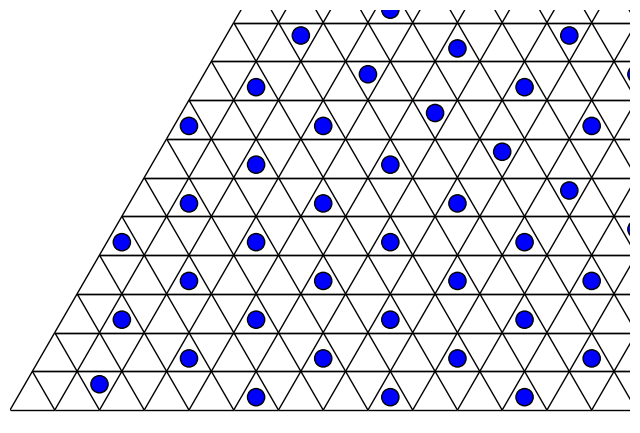

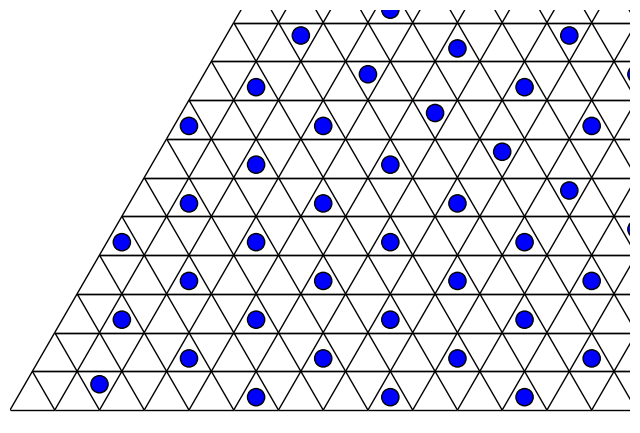

In [12]:
pocket.width = 24
pocket.height = 24
lines = open("pocket.out", "r").readlines()
for line in [lines[10], lines[11]]:
    sample = [[int(i) for i in x[1:-1].split(",")] for x in line.split(" ")[:-1]]
    fig, ax = plt.subplots(1, 1, figsize=[8, 8])
    pocket.draw_hexalattice(ax)
    pocket.show_tiling(ax, (sample, None))
    plt.show()

In [4]:
def load_mc(fname):
    obj = np.load(fname, allow_pickle=True).item()

    if len(next(iter(obj.keys()))) == 3:
        keys = obj.keys()
        xmax = max(x for x,y,d in keys)
        xmin = min(x for x,y,d in keys)
        ymax = max(y for x,y,d in keys)
        ymin = min(y for x,y,d in keys)

        dists = np.zeros((xmax-xmin+1, ymax-ymin+1, 2))
        for key, value in obj.items():
            dists[key[0]-xmin, key[1]-ymin, key[2]] += value
        return dists

    elif len(next(iter(obj.keys()))) == 2:
        keys = obj.keys()
        xmax = max(x for x,y in keys)
        xmin = min(x for x,y in keys)
        ymax = max(y for x,y in keys)
        ymin = min(y for x,y in keys)

        dists = np.zeros((xmax-xmin+1, ymax-ymin+1))
        for key, value in obj.items():
            dists[key[0]-xmin, key[1]-ymin] += value
        return dists

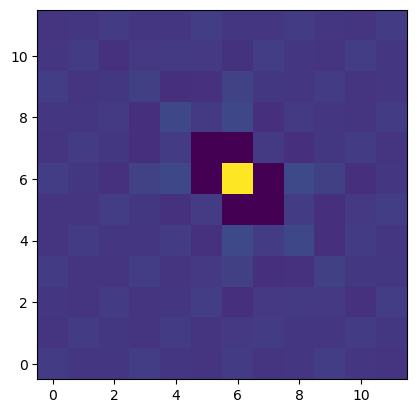

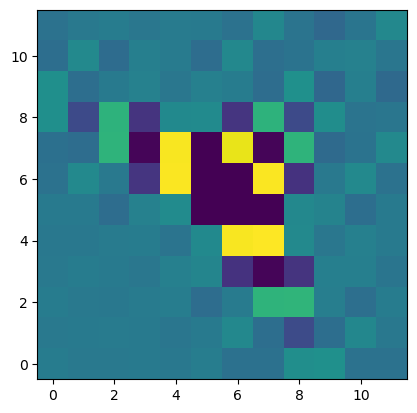

In [7]:
dists = load_mc("data/12x12-3-500000.5-tri-tri-2.npy")
plt.imshow(dists[:, :, 0], origin="lower")
plt.figure()
plt.imshow(dists[:, :, 1], origin="lower")

Text(0.5, 0, '$\\overline{r}$')

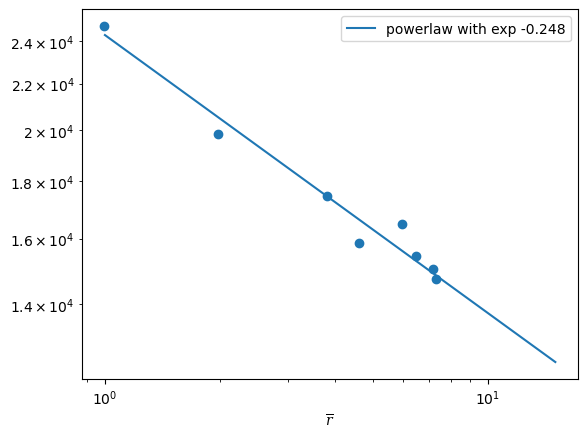

In [121]:
L = len(Xs)
halfXs = Xs[:int(L/2)]
tfXs = np.sin(np.pi/L * halfXs) / (np.pi/L)
halfYs = np.array([dists[x, 0] for x in halfXs])
F = halfYs > 0

plt.scatter(tfXs[F], halfYs[F])

def fit(x, A, B):
    return B * np.power(x, A)

import scipy
P, _ = scipy.optimize.curve_fit(fit, tfXs[F], halfYs[F])

plt.plot(np.linspace(1, 15, 100), fit(np.linspace(1, 15, 100), *P), label=f"powerlaw with exp {P[0]:.3f}")
plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.xlabel("$\\overline{r}$")

Text(0, 0.5, 'density-density (a.u.)')

<Figure size 640x480 with 0 Axes>

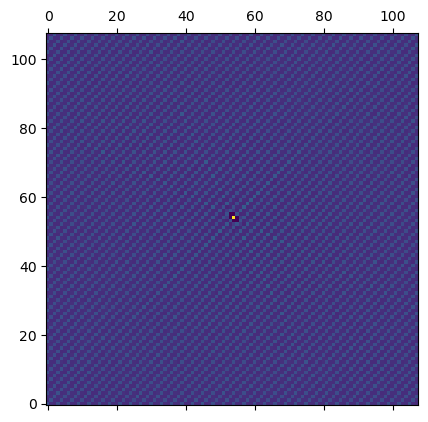

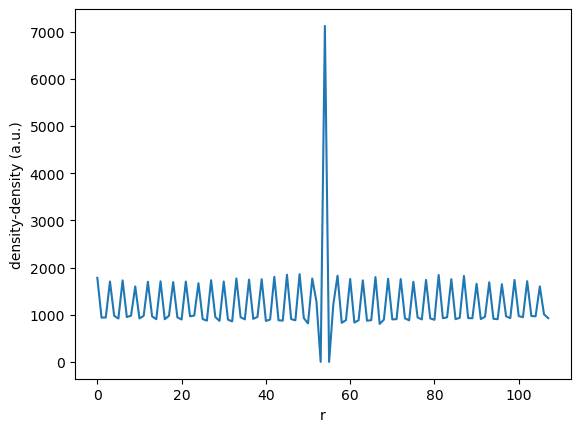

In [5]:
pocket.width = 108
obj = np.load("108x108-3-100000-tri-tri-2.npy", allow_pickle=True).item()
keys = list(obj.keys())
xmax = max(x for x,y in keys)
xmin = min(x for x,y in keys)
ymax = max(y for x,y in keys)
ymin = min(y for x,y in keys)

dists = np.zeros((xmax-xmin+1, ymax-ymin+1))
for key, value in obj.items():
	dists[key[0]-xmin, key[1]-ymin] += value

obj = np.load("108x108-3-100000-tri-tri.npy", allow_pickle=True).item()
for key, value in obj.items():
	dists[key[0]-xmin, key[1]-ymin] += value

plt.figure()
plt.matshow(dists.T, origin="lower")
plt.figure()
plt.plot(dists[:, 54])
plt.xlabel("r")
plt.ylabel("density-density (a.u.)")

[ 57  60  63  66  69  72  75  78  81  84  87  90  93  96  99 102 105]
[1783.  939.  942. 1704.  978.  919. 1728.  951.  980. 1599.  921.  977.
 1699.  966.  906. 1709.  905.  978. 1692.  944.  900. 1704.  967.  982.
 1667.  908.  875. 1732.  951.  870. 1705.  896.  859. 1769.  948.  902.
 1744.  913.  954. 1752.  868.  899. 1804.  883.  875. 1848.  907.  882.
 1861.  930.  817. 1768. 1278.    0. 7122.    0. 1218. 1827.  829.  885.
 1758.  835.  883. 1729.  873.  885. 1799.  806.  897. 1762.  902.  906.
 1756.  924.  882. 1700.  943.  901. 1738.  923.  893. 1842.  927.  945.
 1754.  906.  935. 1822.  929.  925. 1656.  909.  958. 1688.  914.  906.
 1647.  966.  929. 1737.  972.  948. 1710.  972.  967. 1600. 1008.  928.]
[1827. 1758. 1729. 1799. 1762. 1756. 1700. 1738. 1842. 1754. 1822. 1656.
 1688. 1647. 1737. 1710. 1600.]


Text(0.5, 0, '$\\overline{r}$')

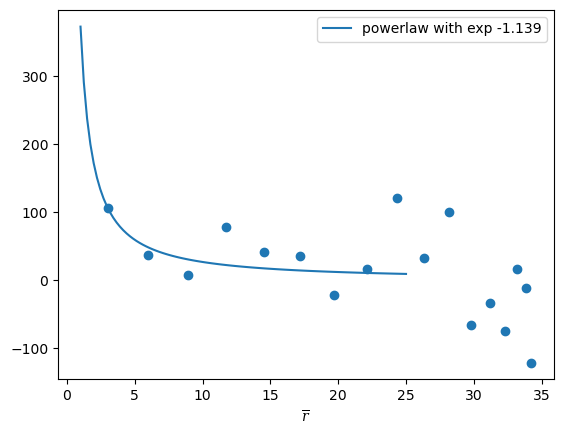

In [7]:
Xs = np.arange(pocket.width)
L = len(Xs)
halfXs = Xs[int(L/2)+3::3]
print(halfXs)
tfXs = np.sin(np.pi/L * (halfXs - L/2)) / (np.pi/L)
halfYs = np.array([dists[x, 54] for x in halfXs])
print(dists[:, 54])
print(halfYs)

halfYs -= halfYs[5:].mean()
# halfYs = np.abs(halfYs)

plt.scatter(tfXs, halfYs)

def fit(x, A, B):
    return B * np.power(x, A)

import scipy
P, _ = scipy.optimize.curve_fit(fit, tfXs, halfYs)

plt.plot(np.linspace(1, 35, 100), fit(np.linspace(1, 35, 100), *P), label=f"powerlaw with exp {P[0]:.3f}")
# plt.xscale("log")
# plt.yscale("log")
plt.legend()
plt.xlabel("$\\overline{r}$")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


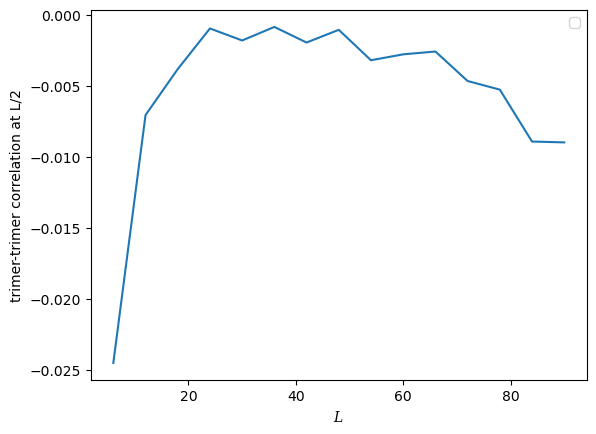

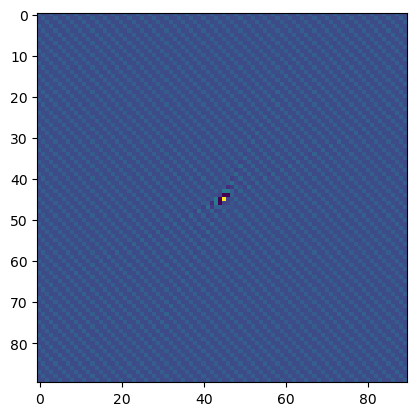

In [2]:
xs = np.arange(6, 96, 6)
ys = []

for i in xs:
	pocket.width = i
	obj = np.load(f"data/{i}x{i}-3-500000.5-tri-tri-2.npy", allow_pickle=True).item()

	keys = list(obj.keys())
	xmax = max(x for x,y,d in keys)
	xmin = min(x for x,y,d in keys)
	ymax = max(y for x,y,d in keys)
	ymin = min(y for x,y,d in keys)

	dists = np.zeros((xmax-xmin+1, ymax-ymin+1))
	for key, value in obj.items():
		if key[2] == 0:
			dists[key[0]-xmin, key[1]-ymin] += value

	# dists = dists / dists.sum() * 2
	dists = dists / dists.sum() * ((i/3)**2*3-1) * ((i/3)**2*3-1)/(i*i) - (1/3/3)

	ys.append(dists[i//2, -1])

# plt.xscale("log")
# plt.yscale("log")
plt.plot(xs, ys)

def fit(x, A, B):
    return B * np.power(x, A)

import scipy
P, _ = scipy.optimize.curve_fit(fit, xs, ys)

# plt.plot(np.linspace(1, 100, 100), fit(np.linspace(1, 100, 100), *P), label=f"powerlaw with exp {P[0]:.3f}")
plt.legend()
plt.xlabel("$L$")
plt.ylabel("trimer-trimer correlation at L/2")


plt.figure()
plt.imshow(dists)

